# Book vocabulary analyser

In [291]:
import pandas as pd
data_raw = pd.read_csv('dataset/unigram_freq.csv')
print(f"Size of reference corpus {len(data_raw)} words")

Size of reference corpus 333333 words


### Non-normalised distribution of corpus frequencies

Size of filtered reference corpus 333181 words


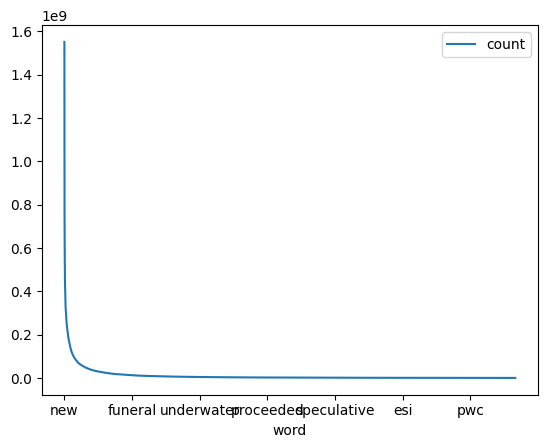

In [292]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

data_filtered = pd.DataFrame(data_raw)
data_filtered['word'].astype(str)
data_filtered['word'].str.lower()
data_filtered['word'] = data_filtered['word'].apply(lambda x: x if x not in stop_words else pd.NA)
data_filtered = data_filtered.dropna().reset_index(drop=True)
data_filtered.head()

data_filtered[:int((1/10)*len(data_filtered))].plot(x="word", y='count')

print(f"Size of filtered reference corpus {len(data_filtered)} words")
pass

Extracting book text  
pdf:

In [371]:
book_path = 'dataset/Blood_Sweat_and_Pixels.epub'

In [ ]:
import pdfplumber
pdf = pdfplumber.open(r''+book_path)
book_text = ''
for page in pdf.pages:
    book_text+=page.extract_text()   

EPUB:

In [372]:
import ebooklib
from ebooklib import epub
book = epub.read_epub(book_path)

book.get_metadata('DC', 'title')
book.get_metadata('DC', 'creator')
book.get_metadata('DC', 'description')
#book.get_metadata('DC', 'language')

[("<p>Developing video games&#8212;hero's journey or fool's errand? The creative and technical logistics that go into building today's hottest games can be more harrowing and complex than the games themselves, often seeming like an endless maze or a bottomless abyss. In Blood, Sweat, and Pixels, Jason Schreier takes readers on a fascinating odyssey behind the scenes of video game development, where the creator may be a team of 600 overworked underdogs or a solitary geek genius. Exploring the artistic challenges, technical impossibilities, marketplace demands, and Donkey Kong-sized monkey wrenches thrown into the works by corporate, Blood, Sweat, and Pixels reveals how bringing any game to completion is more than Sisyphean&#8212;it's nothing short of miraculous.</p><p>Taking some of the most popular, bestselling recent games, Schreier immerses readers in the hellfire of the development process, whether it's RPG studio Bioware's challenge to beat an impossible schedule and overcome...",


In [373]:
# quick fix for python 3.10
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

from epub2txt import epub2txt
book_text = epub2txt(filepath = book_path)

##removing inapropriate symbols 
book_text = book_text.strip()
import re
book_text = re.sub('\n', ' ', book_text)
book_text = re.sub(r'[^\w\s]', ' ', book_text)
book_text = book_text.lower()
book_text[:500]

'cover title page dedication dedication for amanda contents cover title page dedication contents introduction reporting note 1  pillars of eternity 2  uncharted 4 3  stardew valley 4  diablo iii 5  halo wars 6  dragon age  inquisition 7  shovel knight 8  destiny 9  the witcher 3 10  star wars 1313 epilogue acknowledgments about the author praise for blood  sweat  and pixels copyright about the publisher introduction introduction say you want to make a video game  you ve got this killer idea it s '

processing book vocabulary

In [374]:
from nltk.tokenize import word_tokenize
tokenized = word_tokenize(book_text, language = "english")
filtered = []

# Use this to read file content as a stream:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
for r in tokenized:
    if not r in stop_words:
        filtered.append(r)

print(f"without stop words: {len(filtered)} words")

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(w) for w in filtered]


without stop words: 50604 words


In [375]:
import nltk
import numpy as np
from statistics import median
from matplotlib import pyplot as plt

nlp_words = nltk.FreqDist(lemmatized)
print(f"Total amount - {len(nlp_words)} unique word")

Total amount - 7015 unique word


In [382]:
wordlist_dict = dict(nlp_words)
data_book = pd.DataFrame({'word': wordlist_dict.keys(),'count': wordlist_dict.values()})
data_book = data_book.sort_values(by=['count'],ascending=False).reset_index(drop=True)

book_word_freq_mean = data_book["count"].mean()
book_word_freq_std = data_book["count"].std()

most_popular_words = data_book[data_book["count"] > book_word_freq_mean+book_word_freq_std]
most_popular_words

,word,count
0,game,1245
1,would,677
2,said,533
3,like,421
4,one,368
...,...,...
285,running,34
286,thanks,34
287,tell,34
288,tool,34


Red dots are most frequent words in the book.  
Blue line is frequency curve for every word in the book.

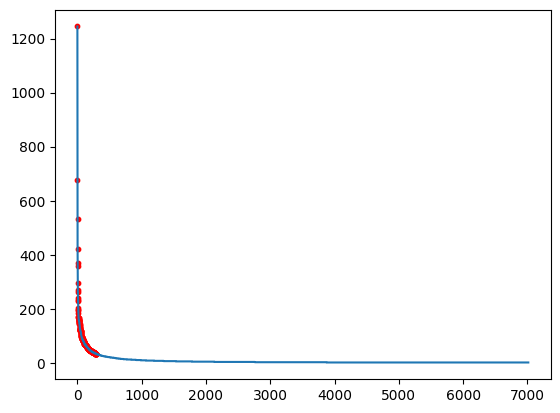

In [383]:
fig = plt.figure()
plt.plot(data_book.index, data_book['count'])
plt.scatter(most_popular_words.index, most_popular_words['count'],  s=10, c='r')
plt.show()

In [384]:
tmp_df = pd.DataFrame(most_popular_words).assign(from_book=lambda x: True)
tmp_df = tmp_df.drop("count", axis = 1)

data_compare = data_filtered.merge(tmp_df, on='word', how='left')

## Illustration of book's vocabulary ordinarity

In [395]:
highlighted = data_compare[data_compare['from_book']==True]

# if word especially rare then it might be ommited in reference dataframe
loss = 100*highlighted["word"].count()/most_popular_words["word"].count()
print(f"Words loss {100-loss:0.3f}%")

Word loss 4.138%


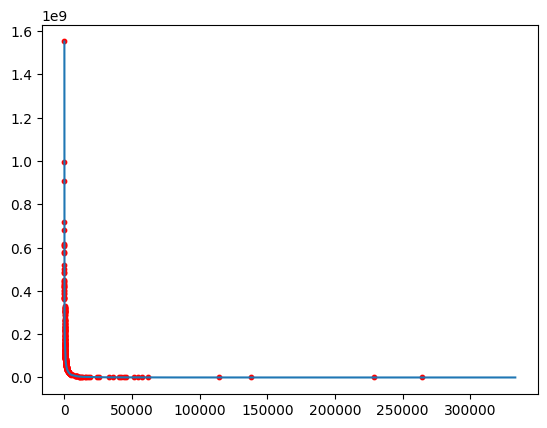

In [396]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(data_compare.index, data_compare['count'])
plt.scatter(highlighted.index, highlighted['count'],  s=10, c='r')
plt.show()

In [397]:
med = highlighted["count"].median()
print(med)
std = highlighted["count"].std()
print(std)
mean = highlighted["count"].mean()
print(mean)
100*med/data_filtered["count"].max()


110041235.0
177010092.803792
160283466.64028776


7.0936742558410355